In [1]:
import sys
import sklearn
from packaging import version

assert sys.version_info >= (3,7)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [2]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [3]:
from helper import save_fig
from sklearn.datasets import fetch_openml # MNIST datasets

mnist_data = fetch_openml('mnist_784', as_frame=False) # not to pd format

C:\Users\alant\AppData\Roaming\Python\Python310\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [4]:
X, y = mnist_data.data, mnist_data.target
X.shape, y.shape

((70000, 784), (70000,))

In [5]:
y[:5]

array(['5', '0', '4', '1', '9'], dtype=object)

In [6]:
import numpy as np 

def plot_digit(image: np.array, title: str) :
    image = image.reshape(28, 28)
    plt.imshow(image, cmap='binary')
    plt.title(title)
    plt.axis('off')

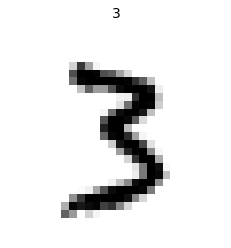

In [7]:
digit_idx = 130
plot_digit(X[digit_idx], y[digit_idx])

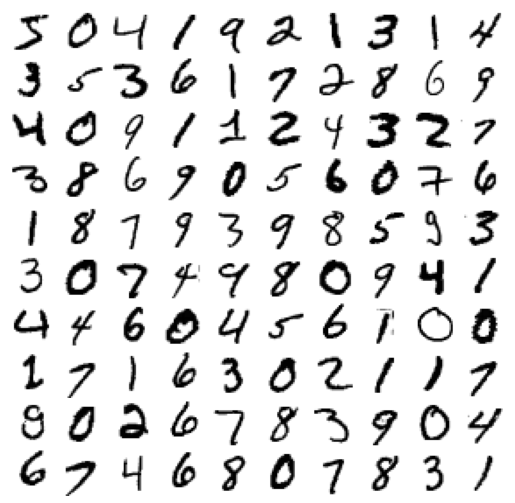

In [8]:
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X[:100]) :
    plt.subplot(10, 10, idx+1)
    plot_digit(image_data, title=None)
plt.subplots_adjust(wspace=0, hspace=0)
save_fig('sample_mnist_dataset')

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((56000, 784), (14000, 784), (56000,), (14000,))

### Binary Classification

In [10]:
y_train_5 = (y_train == '5')*1
y_test_5 = (y_test == '5')*1

In [11]:
print(y_train[:10], y_train_5[:10])

['3' '6' '4' '0' '4' '6' '5' '7' '6' '9'] [0 0 0 0 0 0 1 0 0 0]


In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_accuracy = cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')
print(f'SGD accuracy : {sgd_accuracy}')

SGD accuracy : [0.96233996 0.96700059 0.95130183]


<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*jMs1RmSwnYgR9CsBw-z1dw.png" width=400px/>

In [13]:
# confucsion matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
cm = confusion_matrix(y_train_5, y_train_pred)
print(cm)

[[49744  1169]
 [ 1059  4028]]


In [14]:
#precision and recall
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_train_5, y_train_pred) # TP / (FP + TP)
recall = recall_score(y_train_5, y_train_pred) # TP / (FN + TP)
print(f'precision : {precision:.4f}\nrecall : {recall:.4f}')

precision : 0.7751
recall : 0.7918


In [15]:
cm[1, 1] / ( cm[0,1] + cm[1,1] ) # precision

0.7750625360785068

In [16]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7833527810190588

In [17]:
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [18]:
# Precision/Recall Trade-off
y_score = sgd_clf.decision_function([X[10]]) # like point on prediction axis (then we can select line for seperate class called threshold )
y_score 

array([-9890.4493938])

> The desion function tells us on which side of the hyperplane generated by the classifier we are (and how far we are away from it)

In [19]:
threshold = 0
y_pred_some_digit = (y_score > threshold)
y_pred_some_digit

array([False])

In [20]:
y_score = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [21]:
y_score.shape, y_score[:5]

((56000,),
 array([-13861.2457544 , -37006.01516539, -13080.74481156,  -1845.4211087 ,
        -25749.44910364]))

In [22]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_score)
precisions.shape, recalls.shape, thresholds.shape

((56001,), (56001,), (56000,))

> the last precision and the recall value should be ignored The last precision and recall values are always 1. and 0. respectively and do not have a corresponding threshold.

In [23]:
precisions[-1] ,recalls[-1]

(1.0, 0.0)

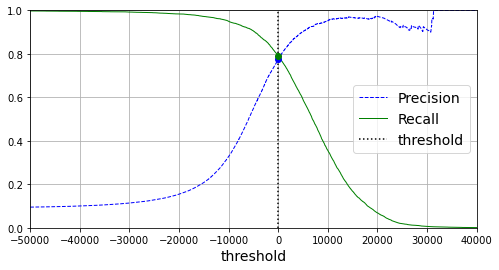

In [24]:
plt.figure(figsize=(8, 4))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision', linewidth=1)
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall', linewidth=1)
plt.vlines(threshold, 0, 1, 'black', 'dotted', label='threshold')

idx = (thresholds >= threshold).argmax() # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], 'bo')
plt.plot(thresholds[idx], recalls[idx], 'go')
plt.axis([-50000, 40000, 0, 1])
plt.grid(True)
plt.xlabel('threshold')
plt.legend(loc='center right')
save_fig(name='precision_recall_x_threshold_plot')

- precision : how many prediction were correct ? //  recommendation system ( should be always good and some content not sure will cut off ), punishment ( for sure )
- recall : how many acutual positive can identify ? // when diagnosis you want all patient can identify ( even someone not but "make sure" all patient can detect ), when youtube restrict age you want to detect what content is 18+ you don't want to show any 18+ content ( even some content not 18+ but have to cut it out )
- idealy is both high score : https://medium.com/analytics-vidhya/precision-recall-tradeoff-for-real-world-use-cases-c6de4fabbcd0

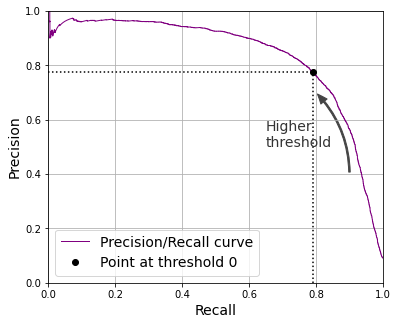

In [25]:
import matplotlib.patches as patches # curved arrow

plt.figure(figsize=(6,5))
plt.plot(recalls, precisions, linewidth=1, label='Precision/Recall curve', c='purple')
plt.plot([recalls[idx], recalls[idx]], [0, precisions[idx]], 'k:')
plt.plot([0, recalls[idx]], [precisions[idx] ,precisions[idx]], 'k:')
plt.plot(recalls[idx], precisions[idx], 'ko', label='Point at threshold 0')

# curved arrow
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.9, 0.4), (0.8, 0.7) , # tail , head (x,u)
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.65, 0.5, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("precision_vs_recall_plot")

In [26]:
# adjust precision or recall score
idx_for_90_precision = (precisions >= 0.9).argmax()
threshold_90_precision = thresholds[idx_for_90_precision]
threshold_90_precision

4869.794908460363

In [27]:
y_train_pred_90 = (y_score >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.9001481481481481

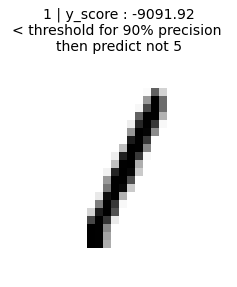

In [30]:
plt.figure(figsize=(4,5))
plot_digit(X_train[16], title=f'{y_train[16]} | y_score : {y_score[16]:.2f}\n< threshold for 90% precision \nthen predict not 5')
save_fig(name='y_score_threshold_and_prediction')

In [31]:
# The ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_score)
fpr.shape, tpr.shape, thresholds.shape

((3292,), (3292,), (3292,))

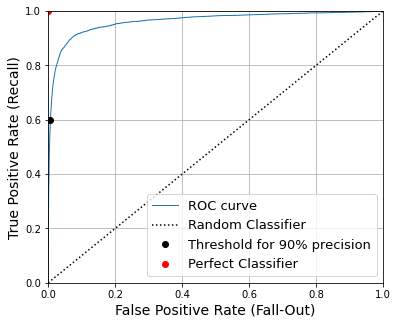

In [59]:
idx_for_threshold_at_90 = (thresholds <= threshold_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, linewidth=1, label='ROC curve')
plt.plot([0,1], [0,1], 'k:', label='Random Classifier')
plt.plot(fpr_90, tpr_90, 'ko', label='Threshold for 90% precision')
plt.plot(0, 1, 'ro', label='Perfect Classifier')
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
save_fig("roc_curve_plot")

In [46]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_score)

0.9625868133048776

In [61]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [66]:
y_probas_forest.shape, y_probas_forest[0] # probas for each class

((56000, 2), array([0.98, 0.02]))

In [70]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

In [75]:
precisions_forest.shape, recalls_forest.shape, thresholds_forest.shape

((102,), (102,), (101,))

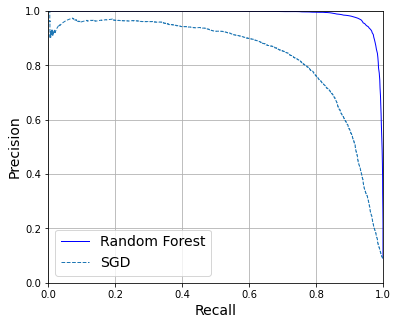

In [79]:
plt.figure(figsize=(6, 5))  

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=1, label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=1, label="SGD")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("pr_curve_comparison_plot")

plt.show()

In [84]:
threshold_forest_at_97_precision = thresholds_forest[(precisions_forest >= 0.97).argmax()]
threshold_forest_at_97_precision

0.38

In [90]:
y_train_pred_forest = y_probas_forest[:, 1] >= threshold_forest_at_97_precision
precision_score(y_train_5, y_train_pred_forest)

0.9714050606871014

In [91]:
roc_auc_score(y_train_5, y_train_pred_forest)

0.9627591645011085

### Multiclass Classification

In [92]:
from sklearn.svm import SVC 

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])

SVC(random_state=42)

In [105]:
svm_clf.predict([X_train[10]]), y_train[10]

(array(['7'], dtype=object), '7')

In [106]:
y_score = svm_clf.decision_function([X_train[10]])
y_score.round(1)

array([[ 5.1, -0.3,  6.2,  8.3,  1.7,  3.8,  0.7,  9.3,  2.9,  7.3]])

In [107]:
class_idx = y_score.argmax()
class_idx

7

In [108]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [114]:
# One versus one
svm_clf.decision_function_shape = 'ovo'
y_score_ovo = svm_clf.decision_function([X_train[10]])
y_score_ovo.round(2)

array([[ 0.6 , -0.24, -0.34,  0.39,  0.27,  0.83, -1.  ,  0.4 , -0.24,
        -0.95, -1.72, -0.26, -0.72, -0.39, -1.55, -1.27, -0.86, -0.28,
         0.57,  0.4 ,  0.84, -1.  ,  0.23, -0.09,  1.17,  1.12,  1.26,
        -0.87,  1.14,  0.5 , -0.26,  0.36, -1.95, -0.63, -1.79,  0.76,
        -1.25,  0.09, -0.65, -1.37, -0.82, -1.07,  1.24,  1.49, -0.41]])

In [117]:
y_score_ovo.shape # 0-1, 0-2, 0-3, 0-4, 0-5, 0-6, 0-7, 0-8, 0-9, 1-2, 1-3 ...

(1, 45)

In [124]:
y_score_ovo.argmax(), y_score_ovo[0][y_score_ovo.argmax()]

(43, 1.4853699625095245)

In [126]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [127]:
ovr_clf.predict([X_train[10]])

array(['7'], dtype='<U1')

In [132]:
ovr_clf.estimators_, len(ovr_clf.estimators_)

([SVC(random_state=42),
  SVC(random_state=42),
  SVC(random_state=42),
  SVC(random_state=42),
  SVC(random_state=42),
  SVC(random_state=42),
  SVC(random_state=42),
  SVC(random_state=42),
  SVC(random_state=42),
  SVC(random_state=42)],
 10)

https://github.com/ageron/handson-ml3/blob/main/03_classification.ipynb